#Necessary imports

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
!pip install -q lightly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 637.1/637.1 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.6/137.6 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.4/722.4 kB 53.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 11.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.2/729.2 kB 45.6 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import copy
import torch
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from torch import nn
import matplotlib.pyplot as plt
from PIL import Image

from tqdm import tqdm

import torch
import torchvision

from torch import nn
from torchvision import transforms

## The projection head is the same as the Barlow Twins one
from lightly.loss import VICRegLoss

## The projection head is the same as the Barlow Twins one
from lightly.loss.vicreg_loss import VICRegLoss
from lightly.models.modules import BarlowTwinsProjectionHead
from lightly.transforms.vicreg_transform import VICRegTransform


from lightly.data import LightlyDataset
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda', index=0)

In [4]:
def reproducibility(SEED):
    torch.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(SEED)

reproducibility(42)

#Define model

In [5]:
backbone = torch.hub.load('facebookresearch/swav:main', 'resnet50')

Downloading: "https://github.com/facebookresearch/swav/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/deepcluster/swav_800ep_pretrain.pth.tar" to /root/.cache/torch/hub/checkpoints/swav_800ep_pretrain.pth.tar
100%|██████████| 108M/108M [00:00<00:00, 206MB/s]


In [6]:
class VICReg(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone
        self.projection_head = BarlowTwinsProjectionHead(512, 2048, 2048)

    def forward(self, x):
        x = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(x)
        return z

#Data (cifar10 or cifar100)

In [8]:
def get_input_stats(dataset):
    if dataset == 'cifar_100':
        data_mean, data_std = (0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762)
    elif dataset == 'cifar_10':
        data_mean, data_std = (0.4914, 0.4822, 0.4465), (0.2471, 0.2435, 0.2616)

    return data_mean, data_std

In [9]:
resnet = torchvision.models.resnet18()
backbone = nn.Sequential(*list(resnet.children())[:-1])
model = VICReg(backbone)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
print()

In [10]:
transform = VICRegTransform(input_size=32)
cifar10 = torchvision.datasets.CIFAR10("datasets/cifar10", download=True)

data_mean, data_std = get_input_stats('cifar_10')
normalize_dict = {'mean': data_mean, 'std': data_std}

dataset = LightlyDataset.from_torch_dataset(cifar10, transform=transform)

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=128,
    shuffle=True,
    drop_last=True,
    num_workers=2,
    pin_memory=True
)

100%|██████████| 170498071/170498071 [00:13<00:00, 13091110.35it/s]


Extracting datasets/cifar10/cifar-10-python.tar.gz to datasets/cifar10


#Optimizer and Scheduler

In [11]:
criterion = VICRegLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.06)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,gamma=0.85)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer,base_lr=0.01, max_lr=0.1)
n_epochs, max_norm = 20, 0.1

#KNN and dataloaders for evaluation

In [12]:
from torchvision import transforms as T
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

BATCH_SIZE = 128

test_transform = T.Compose([
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) ])

def get_cifar10_dataloader(batch_size, train=True, transform=test_transform):
    dataset = CIFAR10(root="./", train=train, transform=transform, download=True)
    return DataLoader(dataset=dataset, batch_size=batch_size, num_workers=4, drop_last=True)


loader_train_plain = get_cifar10_dataloader(batch_size=BATCH_SIZE, train=True, transform=test_transform)
loader_test = get_cifar10_dataloader(batch_size=BATCH_SIZE, train=False, transform=test_transform)

100%|██████████| 170498071/170498071 [00:13<00:00, 12900681.47it/s]


Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


In [13]:
class KNN():
    def __init__(self, model, k, device):
        super(KNN, self).__init__()
        self.k = k
        self.device = device
        self.model = model.to(device)
        self.model.eval()

    def extract_features(self, loader):
        x_lst = []
        features = []
        label_lst = []

        with torch.no_grad():
            for input_tensor, label in loader:
                h = self.model(input_tensor.to(self.device))
                features.append(h)
                x_lst.append(input_tensor)
                label_lst.append(label)

            x_total = torch.stack(x_lst)
            h_total = torch.stack(features)
            label_total = torch.stack(label_lst)

            return x_total, h_total, label_total

    def knn(self, features, labels, k=1):
        """
        Evaluating knn accuracy in feature space.
        Calculates only top-1 accuracy (returns 0 for top-5)
        Args:
            features: [... , dataset_size, feat_dim]
            labels: [... , dataset_size]
            k: nearest neighbours
        Returns: train accuracy, or train and test acc
        """
        feature_dim = features.shape[-1]
        with torch.no_grad():
            features_np = features.cpu().view(-1, feature_dim).numpy()
            labels_np = labels.cpu().view(-1).numpy()
            # fit
            self.cls = KNeighborsClassifier(k, metric='cosine').fit(features_np, labels_np)
            acc = self.eval(features, labels)

        return acc

    def eval(self, features, labels):
      feature_dim = features.shape[-1]
      features = features.cpu().view(-1, feature_dim).numpy()
      labels = labels.cpu().view(-1).numpy()
      acc = 100 * np.mean(cross_val_score(self.cls, features, labels))
      return acc

    def _find_best_indices(self, h_query, h_ref):
        h_query = h_query / h_query.norm(dim=1).view(-1, 1)
        h_ref = h_ref / h_ref.norm(dim=1).view(-1, 1)
        scores = torch.matmul(h_query, h_ref.t())  # [query_bs, ref_bs]
        score, indices = scores.topk(1, dim=1)  # select top k best
        return score, indices

    def fit(self, train_loader, test_loader=None):
        with torch.no_grad():
            x_train, h_train, l_train = self.extract_features(train_loader)
            train_acc = self.knn(h_train, l_train, k=self.k)

            if test_loader is not None:
                x_test, h_test, l_test = self.extract_features(test_loader)
                test_acc = self.eval(h_test, l_test)
                return train_acc, test_acc

#Make directory for saving models

In [14]:
!mkdir models

In [15]:
ssl_evaluator = KNN(model=model, k=1, device=device)
train_acc, val_acc = ssl_evaluator.fit(loader_train_plain, loader_test)

In [16]:
print(train_acc, val_acc)

33.55168269230769 28.345413912451846


In [19]:
best_val_acc = 0
print("Starting Training")
for epoch in tqdm(range(n_epochs)):
    total_loss = 0
    for batch in dataloader:
        x0, x1 = batch[0]
        x0 = x0.to(device)
        x1 = x1.to(device)
        z0 = model(x0)
        z1 = model(x1)
        loss = criterion(z0, z1)
        total_loss += loss.detach()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    scheduler.step()
    avg_loss = total_loss / len(dataloader)
    print(f"\n epoch: {epoch:>02}, loss: {avg_loss:.5f}")
    ssl_evaluator = KNN(model=model, k=1, device='cuda')
    train_acc, val_acc = ssl_evaluator.fit(loader_train_plain, loader_test)
    if val_acc > best_val_acc:
        torch.save(model.state_dict(),f'models/SimCLR_model_acc{val_acc:.2f}.pt')
        best_val_acc = val_acc
    print(f'\n Train Accuracy:{train_acc:.1f}%',f' Val Accuracy:{val_acc:.1f}%')

Starting Training


  0%|          | 0/20 [00:00<?, ?it/s]


 epoch: 00, loss: 21.75465


  5%|▌         | 1/20 [04:22<1:23:04, 262.33s/it]


 Train Accuracy:29.3%  Val Accuracy:27.1%

 epoch: 01, loss: 21.53829


 10%|█         | 2/20 [08:40<1:17:55, 259.77s/it]


 Train Accuracy:31.7%  Val Accuracy:29.4%

 epoch: 02, loss: 21.41417


 15%|█▌        | 3/20 [13:00<1:13:40, 260.04s/it]


 Train Accuracy:32.5%  Val Accuracy:30.8%

 epoch: 03, loss: 21.32404


 20%|██        | 4/20 [17:21<1:09:25, 260.37s/it]


 Train Accuracy:34.7%  Val Accuracy:32.0%

 epoch: 04, loss: 21.19554


 25%|██▌       | 5/20 [21:43<1:05:16, 261.11s/it]


 Train Accuracy:36.5%  Val Accuracy:34.0%

 epoch: 05, loss: 21.12375


 30%|███       | 6/20 [26:06<1:01:01, 261.55s/it]


 Train Accuracy:36.9%  Val Accuracy:34.3%

 epoch: 06, loss: 21.07989


 35%|███▌      | 7/20 [30:23<56:19, 259.94s/it]  


 Train Accuracy:37.7%  Val Accuracy:34.7%

 epoch: 07, loss: 20.99496


 40%|████      | 8/20 [34:42<51:56, 259.72s/it]


 Train Accuracy:38.7%  Val Accuracy:35.8%

 epoch: 08, loss: 20.96409


 45%|████▌     | 9/20 [38:58<47:24, 258.61s/it]


 Train Accuracy:39.0%  Val Accuracy:36.4%

 epoch: 09, loss: 20.92758


 50%|█████     | 10/20 [43:13<42:54, 257.40s/it]


 Train Accuracy:39.6%  Val Accuracy:36.5%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ae3ebba0670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ae3ebba0670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/


 epoch: 10, loss: 20.90228


 55%|█████▌    | 11/20 [47:28<38:31, 256.79s/it]


 Train Accuracy:40.0%  Val Accuracy:36.7%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ae3ebba0670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ae3ebba0670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/


 epoch: 11, loss: 20.86665


 60%|██████    | 12/20 [51:46<34:16, 257.02s/it]


 Train Accuracy:40.0%  Val Accuracy:36.8%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ae3ebba0670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ae3ebba0670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/


 epoch: 12, loss: 20.82692


 65%|██████▌   | 13/20 [56:02<29:58, 256.90s/it]


 Train Accuracy:40.5%  Val Accuracy:37.4%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ae3ebba0670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ae3ebba0670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/


 epoch: 13, loss: 20.80947


 70%|███████   | 14/20 [1:00:15<25:33, 255.57s/it]


 Train Accuracy:41.0%  Val Accuracy:37.4%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ae3ebba0670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ae3ebba0670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/


 epoch: 14, loss: 20.77990


 75%|███████▌  | 15/20 [1:04:32<21:20, 256.16s/it]


 Train Accuracy:41.7%  Val Accuracy:38.1%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ae3ebba0670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ae3ebba0670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/


 epoch: 15, loss: 20.74276


 80%|████████  | 16/20 [1:08:48<17:04, 256.19s/it]


 Train Accuracy:41.7%  Val Accuracy:38.7%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ae3ebba0670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ae3ebba0670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/


 epoch: 16, loss: 20.75251


 85%|████████▌ | 17/20 [1:13:01<12:44, 255.00s/it]


 Train Accuracy:42.6%  Val Accuracy:39.4%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ae3ebba0670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ae3ebba0670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/


 epoch: 17, loss: 20.73063


 90%|█████████ | 18/20 [1:17:15<08:29, 254.69s/it]


 Train Accuracy:43.0%  Val Accuracy:39.4%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ae3ebba0670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ae3ebba0670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/


 epoch: 18, loss: 20.69749


 95%|█████████▌| 19/20 [1:21:31<04:15, 255.11s/it]


 Train Accuracy:43.7%  Val Accuracy:40.4%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ae3ebba0670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ae3ebba0670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/


 epoch: 19, loss: 20.68065


100%|██████████| 20/20 [1:25:44<00:00, 257.23s/it]


 Train Accuracy:44.2%  Val Accuracy:40.7%


#Load best model we have got

In [20]:
model.load_state_dict(torch.load('models/SimCLR_model_acc40.73.pt'))

<All keys matched successfully>

#Visual evaluation

In [21]:
transform_clean = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(data_mean, data_std),
])

dataset = LightlyDataset.from_torch_dataset(cifar10, transform=transform_clean)

dataloader_test = torch.utils.data.DataLoader(
    dataset, batch_size=128, shuffle=False, drop_last=True, num_workers=1,
)

In [22]:
backbone = backbone.to(DEVICE)

In [23]:
def generate_embeddings(model, dataloader):
    embeddings, filenames, labels = [], [], []
    with torch.no_grad():
        for img, label, fnames in dataloader:
            img = img.to(DEVICE)
            emb = model(img).flatten(start_dim=1).cpu()
            embeddings.append(emb)
            filenames.extend(fnames)
            labels.extend(label)
            break

    embeddings = torch.cat(embeddings, 0)
    embeddings = normalize(embeddings)
    return embeddings, filenames, labels

# backbone.eval()
# backbone = model.backbone
backbone.eval()
embeddings, filenames, labels = generate_embeddings(backbone, dataloader_test)

In [24]:
def class_name(index):
    return cifar10.classes[index.item()]

In [25]:
path_to_data = '/content/datasets/' + 'cifar10'

def get_image_as_np_array(filename: str):
    """Returns an image as an numpy array"""
#     img = Image.open(filename)
#     return np.asarray(img)
    img = dataset[int(filename)][0]
    return np.clip(img.permute(1, 2, 0).numpy(),0,1)

def plot_knn_examples(embeddings, filenames, labels, n_neighbors=5, num_examples=6):
    """Plots multiple rows of random images with their nearest neighbors"""
    # lets look at the nearest neighbors for some samples; we use the sklearn library
    nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(embeddings)
    distances, indices = nbrs.kneighbors(embeddings)

    # get n random samples
    samples_idx = np.random.choice(len(indices), size=num_examples, replace=False)

    # loop through our randomly picked samples
    fig,axes = plt.subplots(num_examples,n_neighbors,figsize=(40,40),constrained_layout=True)
    for example_index,idx in tqdm(enumerate(samples_idx)):
        # loop through their nearest neighbors
        for plot_x_offset, neighbor_idx in enumerate(indices[idx]):
            # add the subplot
            image = get_image_as_np_array(filenames[neighbor_idx])
            axes[example_index,plot_x_offset].imshow(image)
            axes[example_index,plot_x_offset].set_title(class_name(labels[neighbor_idx]) + ' ' + f"d={distances[idx][plot_x_offset]:.3f}")
            plt.axis("off")
    plt.savefig('knn_examples.png')

7it [00:00, 79.71it/s]


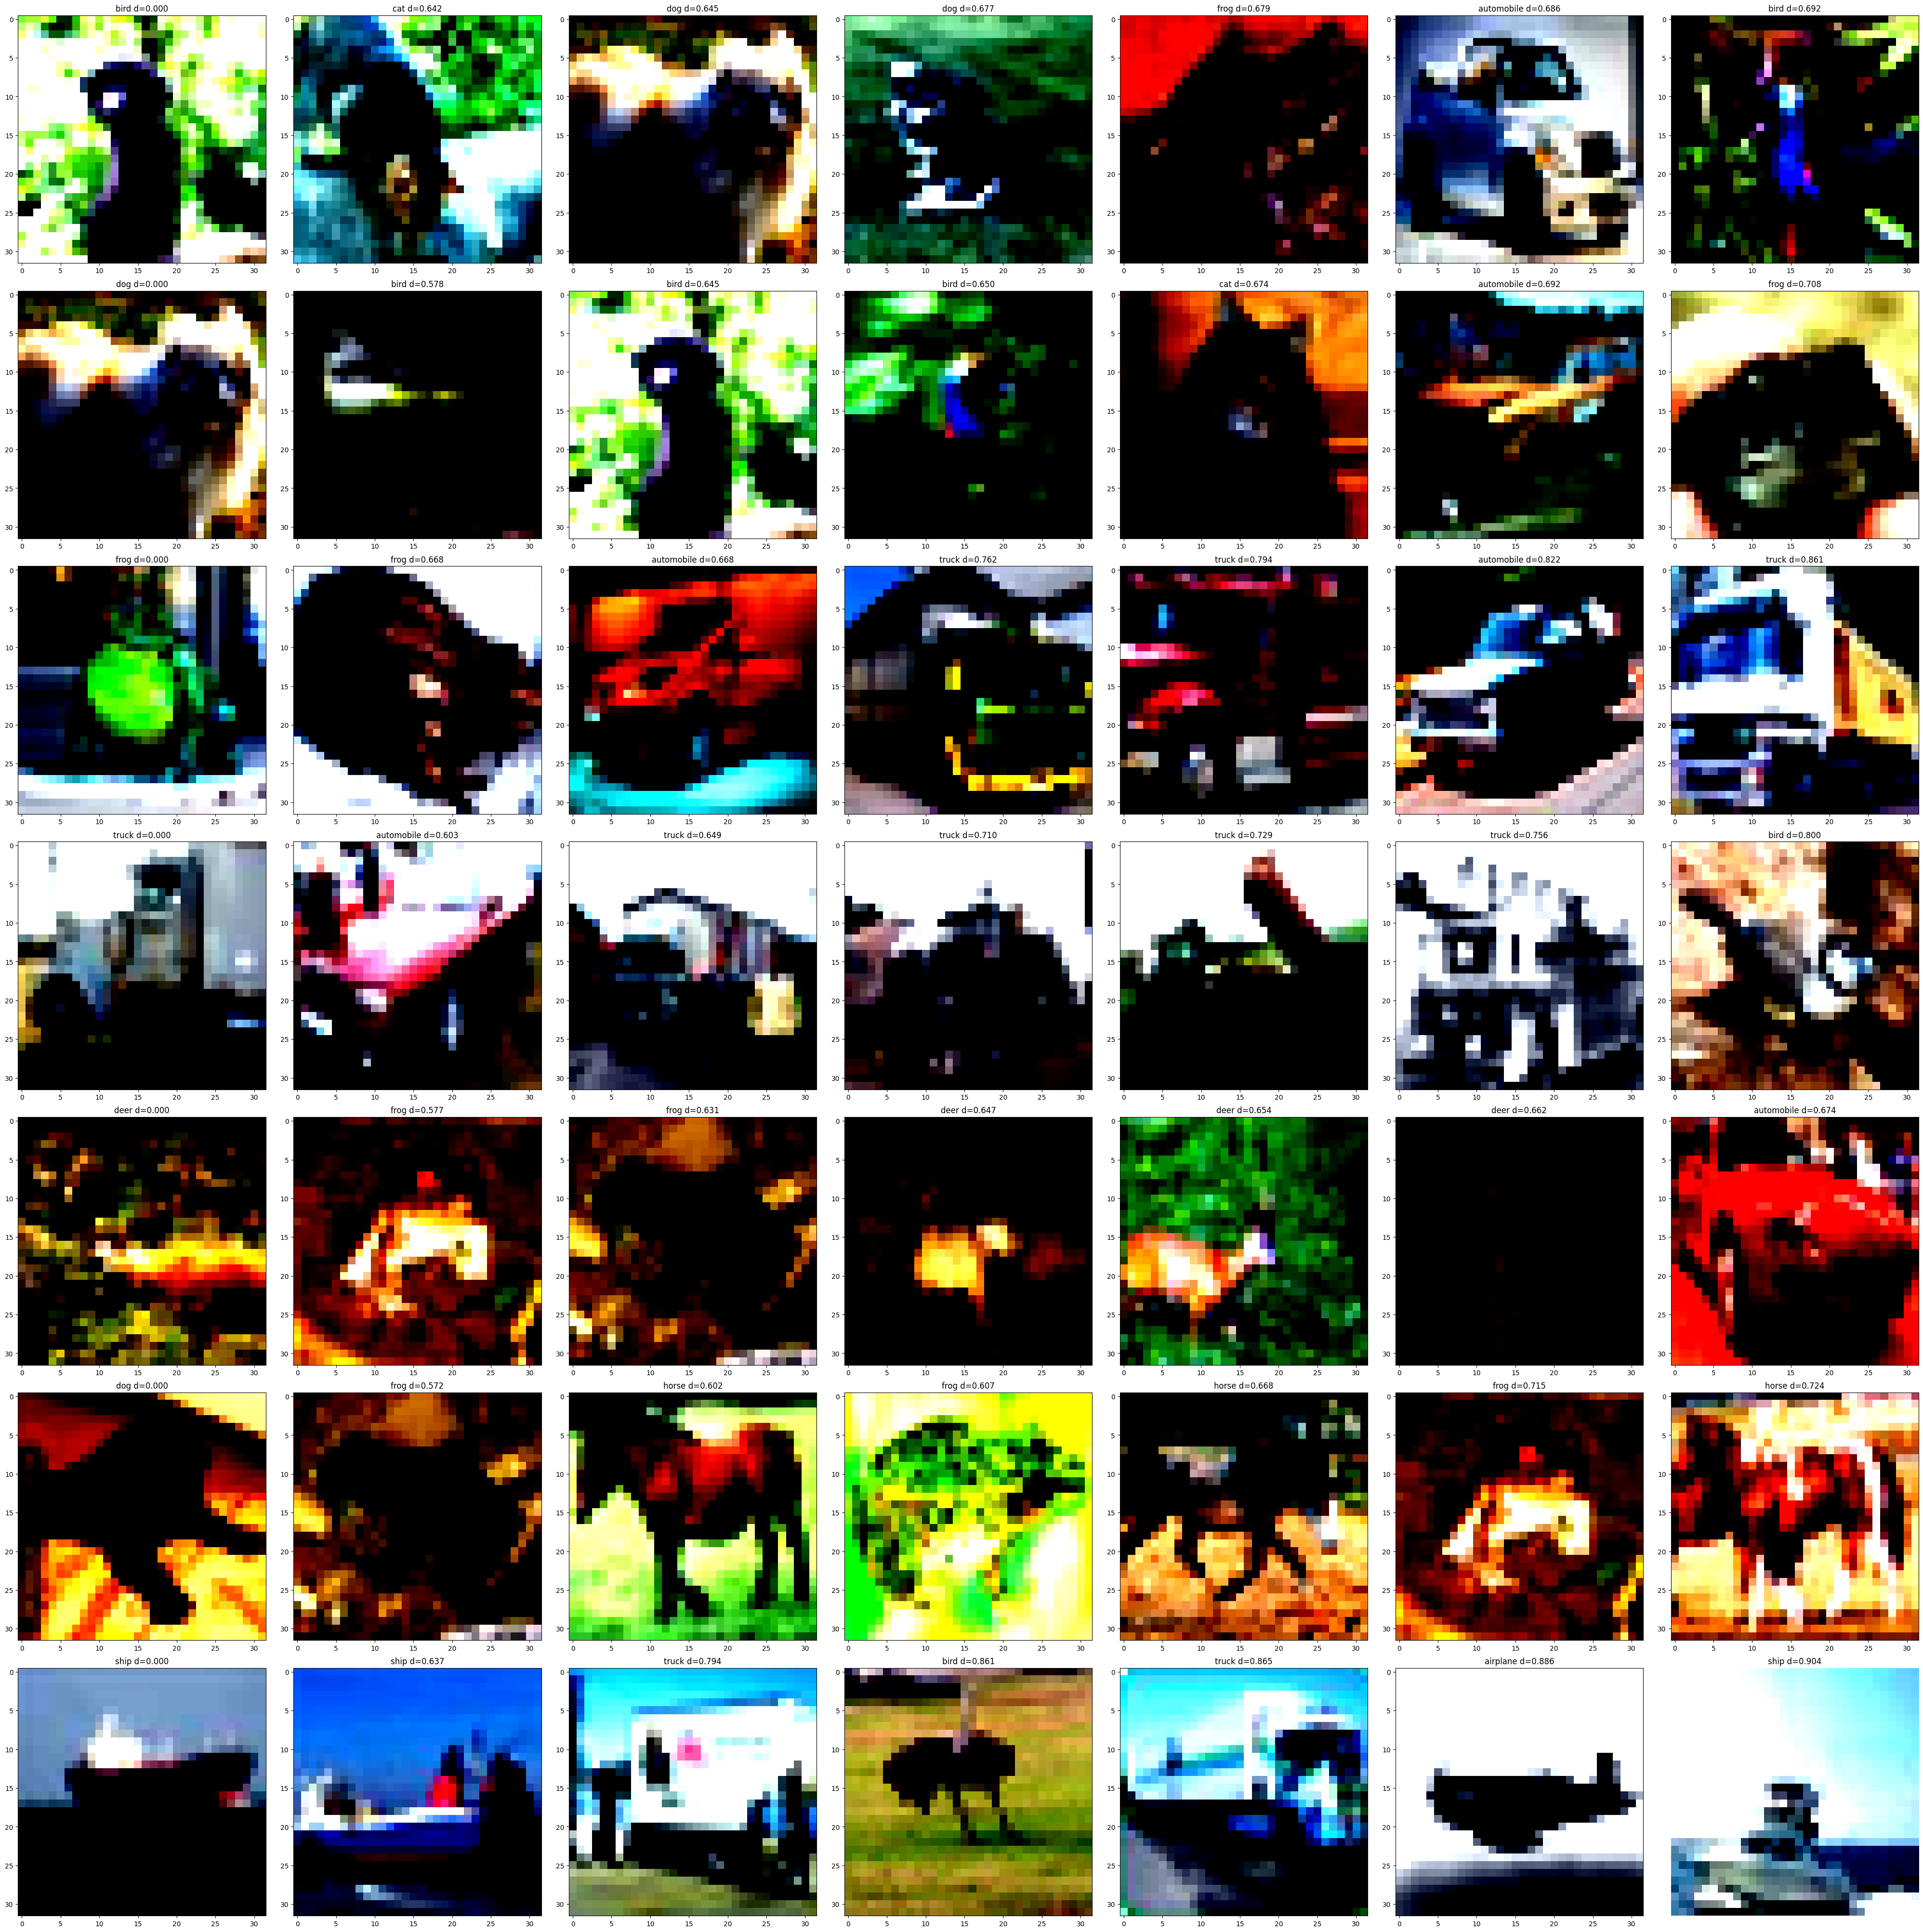

In [26]:
plot_knn_examples(embeddings, filenames, labels, num_examples=7, n_neighbors=7)

#Save backbone model

In [28]:
torch.save(backbone.state_dict(), 'model_cifar_10_vicreg40.73.pt')